## Exploratory Data Storytelling
Pick a dataset (ideally the dataset for your Capstone). If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.

Get going by asking the following questions and looking for the answers with some code and plots:
* Can you count something interesting?
* Can you find some trends (high, low, increase, decrease, anomalies)?
* Can you make a bar plot or a histogram?
* Can you compare two related quantities?
* Can you make a scatterplot?
* Can you make a time-series plot?

Having made these plots, what are some insights you get from them? 
* Do you see any correlations? 
* Is there a hypothesis you would like to investigate further? 
* What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. 
* Is there an interesting narrative that tells a compelling story? 
* What are some other trends/relationships you think will make it more complete?

Submission Requirements: The notebook should contain:

* The questions you asked
* The trends you investigated
* The resulting visualizations and conclusions.

If the data set is too large to commit, please include a link to the data set inside the Jupyter notebook.

### Introduction
The aim with the Citibike data is to explore human dynamics associated with trips.  In this case, it focuses more on the age category because generation dynamics is important for something substantial as bike sharing.  Bikes have been prominent for a long time; however, bike sharing became widespread at the start of the 2010s to reduce greenhouse gases and carbon emissions.  

Here, possible hypotheses involve:

* younger users (subscribers and customers) leverage the bike sharing program more
* customers leverage bike share on the weekends
* probably peaks include start and end to workdays and middle day weekends (i.e. 10 am - 3 pm Saturday)

Please keep in mind, these are possible hypotheses based on experience, not data!  The process for exploring the data includes the following:

* What story does the data tell without the group parameter
* With the group parameter, is the story consistent with the original?  
* What needs to be explored further?
* What hypothesis is worth checking out after reviewing the data?

To explore the group is to explore the dataset.  This will explore the data before adding the group parameter to simplify the user's birth year.  

### Setup 
First let's setup the execution and perform a simple exploratory data analysis.  

In [335]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [336]:
sample = pd.read_csv('story_data.csv')

In [337]:
sample.shape

(1557663, 15)

In [338]:
sample.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,288,8/1/2016 00:01:22,8/1/2016 00:06:11,302,Avenue D & E 3 St,41,-74,428,E 3 St & 1 Ave,41,-74,16920,Subscriber,1961,1
1,457,8/1/2016 00:01:43,8/1/2016 00:09:21,285,Broadway & E 14 St,41,-74,432,E 7 St & Avenue A,41,-74,20084,Subscriber,1989,2
2,278,8/1/2016 00:02:10,8/1/2016 00:06:49,539,Metropolitan Ave & Bedford Ave,41,-74,3096,Union Ave & N 12 St,41,-74,18380,Subscriber,1971,1
3,862,8/1/2016 00:02:13,8/1/2016 00:16:36,280,E 10 St & 5 Ave,41,-74,280,E 10 St & 5 Ave,41,-74,24101,Subscriber,1995,1
4,407,8/1/2016 00:02:21,8/1/2016 00:09:09,161,LaGuardia Pl & W 3 St,41,-74,428,E 3 St & 1 Ave,41,-74,18949,Subscriber,1993,1


In [339]:
pd.options.display.float_format = '{:.0f}'.format

In [340]:
sample['starttime'] = pd.to_datetime(sample['starttime'])

In [341]:
sample['stoptime'] = pd.to_datetime(sample['stoptime'])

In [342]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557663 entries, 0 to 1557662
Data columns (total 15 columns):
tripduration               1557663 non-null int64
starttime                  1557663 non-null datetime64[ns]
stoptime                   1557663 non-null datetime64[ns]
start station id           1557663 non-null int64
start station name         1557663 non-null object
start station latitude     1557663 non-null float64
start station longitude    1557663 non-null float64
end station id             1557663 non-null int64
end station name           1557663 non-null object
end station latitude       1557663 non-null float64
end station longitude      1557663 non-null float64
bikeid                     1557663 non-null int64
usertype                   1557663 non-null object
birth year                 1343039 non-null float64
gender                     1557663 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(5), object(3)
memory usage: 178.3+ MB


In [343]:
sample.isnull().sum()

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  0
end station name                0
end station latitude            0
end station longitude           0
bikeid                          0
usertype                        0
birth year                 214624
gender                          0
dtype: int64

#### Summary
The variables 'starttime' and 'stoptime' now have the datetime64 data type, making it easier to use the build-in functions to explore the date and time in numerous ways.  Also, with one month, there are 214,624 trips without a birth year.  It is possible that they could all be customers, since they don't require a birth year to purchase a day pass.

The data itself has more categorical information than non-categorical.  Only trip duration, the time the bike was used between checking out the bike and return it back to another hub, is numerical to explore further.  Everything else must rely on its counts and calculations.  The significant attributes for this set are:

* Trip duration
* Start time
* Stop time
* User type
* Birth year
* Gender

Others, especially the station details, may come in handy in the visualization, but not right now. 

### PART 1 - Define Age Group
This group will make it easier to work with birth year moving forward.  Rather than worry about 100 groups, this will focus on five.  

* **0 UNK**: Those born before 1945
* **1 SEN**: Those who are elderly, born between 1945 - 1960
* **2 ADL**: Those born between 1960 - 1985
* **3 JNR**: Those born between 1985 - 2000
* **4 YNG**: Those born 2000 after

In [347]:
def get_group(row):
    if (row['birth year'] >= 2000):
        return '4 YNG'
    elif (row['birth year'] >= 1985) & (row['birth year'] < 2000):
        return '3 JNR'
    elif (row['birth year'] >= 1960) & (row['birth year'] < 1985):
        return '2 ADL'
    elif (row['birth year'] >= 1945) & (row['birth year'] < 1960):
        return '1 SEN'
    else :
        return '0 UNK'

In [348]:
sample['agegroup'] = sample.apply(get_group, axis=1)

In [496]:
sample.groupby('agegroup').size().sort_index()

agegroup
0 UNK    219878
1 SEN     98826
2 ADL    732540
3 JNR    505780
4 YNG       639
dtype: int64

In [494]:
np.median(sample[sample['birth year'].notnull()]['birth year']).astype(int)

1981

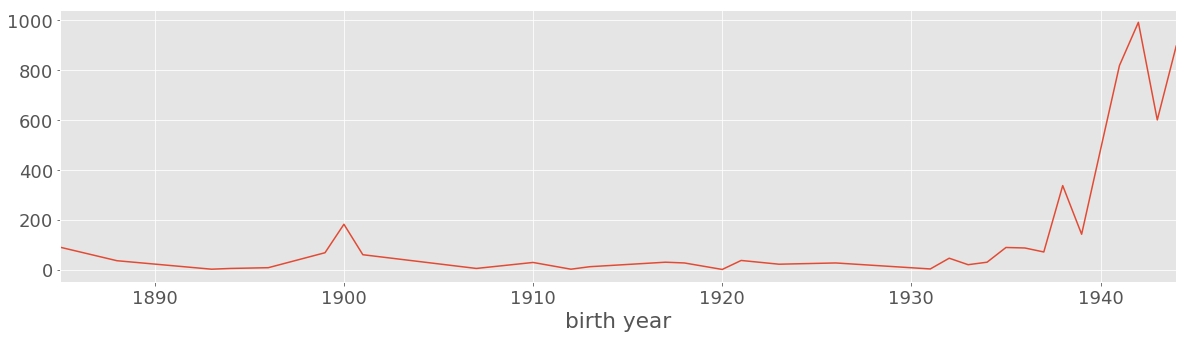

In [415]:
sample[sample['agegroup'] == '0 UNK'].groupby('birth year').size().sort_index().plot(figsize=(20,5))

After creating the separate groups, two groups make up majority of the active users, born from the 1960s to late 1990s.  The median birth year, among those specified, was 1981.  The maximum birth year was 2000.  Preliminary investigation showed all 638 trips operated by users who were born in the year 2000.   

Looking at the unknown group gives a lengthy range.  However, some users in the unknown group include senior    citizens who were born in the late 1930s.  This large spike is rational, versus the mini-spike from 1900.  The mini-spike could be incorrect prompts or defaulted areas.  For example, 1900 may curtail anyone born in the 20th century.  But these are mininscule (with the threshold hovering around 200).

### PART 2 - Explore Data before Group
Before exploring information using the group information, let's explore the data as is.

The significant variables are:
* Trip duration (numerical)
* Birth year (categorical)
* User type (categorical, customer or subscriber)
* Gender (categorical, male female or other)
* Start time
* Stop time

Possible explorations include:
* Who: 
    * Marginal distribution of gender
    * Who: Marginal distribution of user type
    * Who: Marginal distribution by age
* When: 
    * Histogram of trip durations
    * Daily count of checkouts by hour
    * Weekly count of checkouts by day
* How: 
    * Trip duration by birth year
    * Trip duration boxplot by gender
    * Trip duration boxplot by user type

In [525]:
# WHO / Marginal distributions: This utilizes a histogram or bar chart to show the distribution of records
bar_gender = sample.groupby('gender')['gender'].count()
bar_user = sample.groupby('usertype')['usertype'].size()

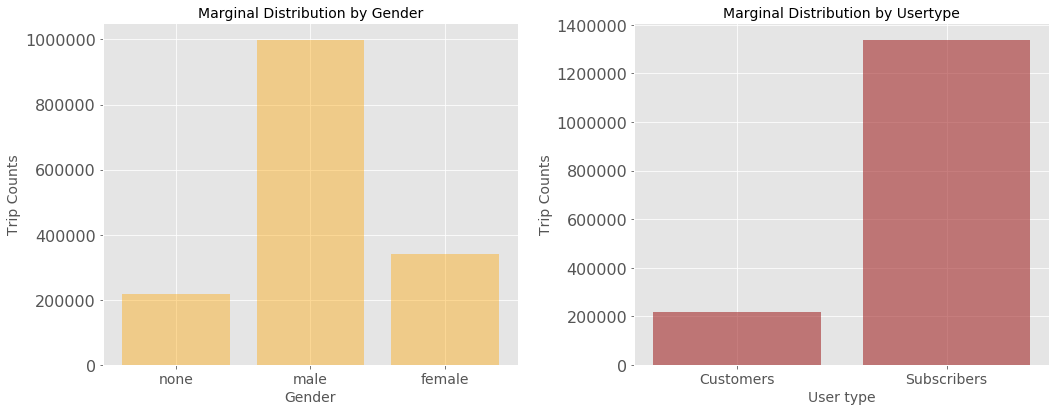

In [744]:
fig, ax = plt.subplots(1,2,figsize=[15,6])

# Marginal distribution by gender
genders = ['none','male','female']
ax[0].bar([0,1,2], bar_gender, align='center', color='orange', alpha=0.4)
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['none', 'male', 'female', ' '], fontsize=14)
ax[0].set_xlabel('Gender', fontsize=14)
ax[0].set_ylabel('Trip Counts', fontsize=14)
ax[0].set_title('Marginal Distribution by Gender', fontsize=14)

# Marginal distribution by user type
users = ['Customers', 'Subscribers']
ax[1].bar([0,1], bar_user, align='center', color='brown', alpha=0.6)
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(users, fontsize=14)
ax[1].set_xlabel('User type', fontsize=14)
ax[1].set_ylabel('Trip Counts', fontsize=14)
ax[1].set_title('Marginal Distribution by Usertype', fontsize=14)

plt.tight_layout()
plt.show()

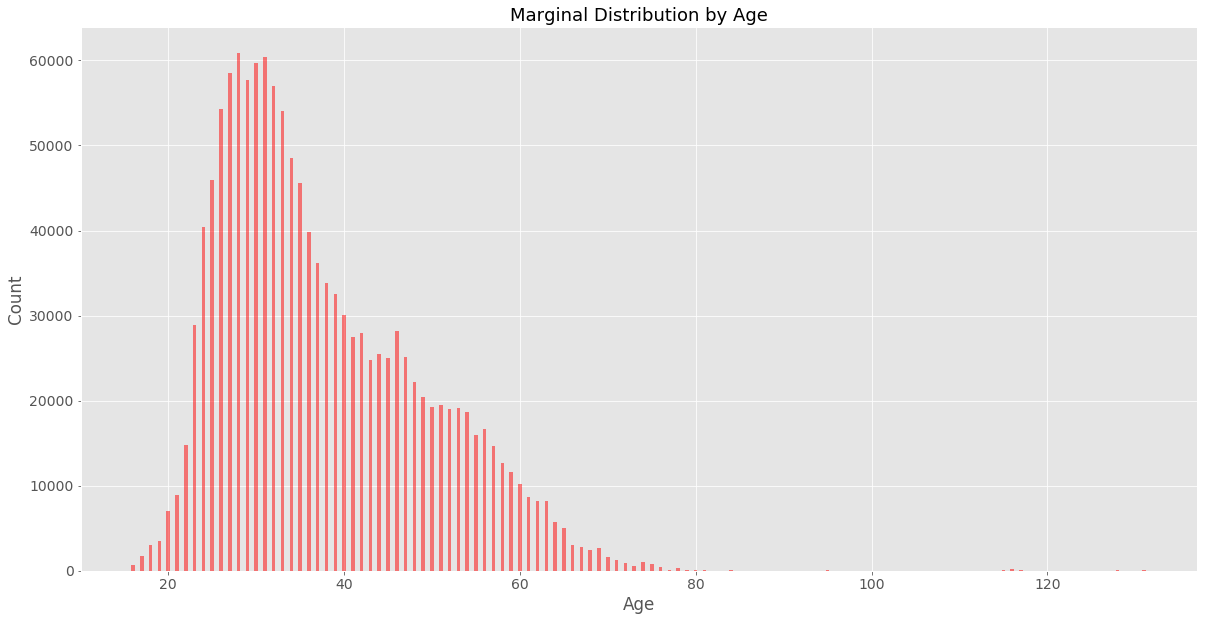

In [183]:
# Marginal distribution by age
age_col = 2016.0 - sample['birth year'].dropna().values

hist_age = np.unique(age_col, return_counts=True)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':14})
plt.bar(hist_age[0], hist_age[1], align='center', color='red', width=0.4, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Marginal Distribution by Age', fontsize=18)
plt.show()

Regarding 'Who', the marginal distributions don't yearn any further inquiries at first.  
* The distribution by gender shows more males than females utilize the bike share.  
* Also, by usertype shows more subscribers than customers.  
* By age shows a skewed right distribution.  This is heavily favored among those in their young adulthood (22 - 34).  

Therefore, the marginal distribution in age is worth investigating.  

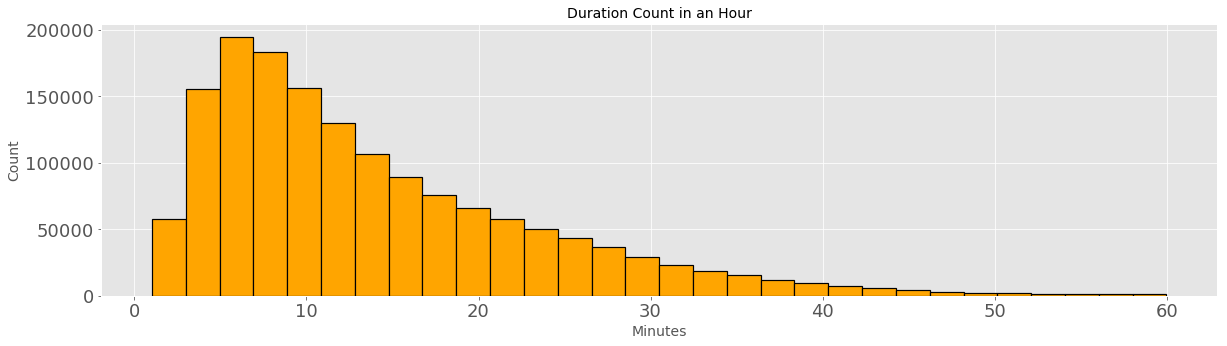

In [539]:
# WHEN / Count by time: Trip count by trip duration, hourly checkout, daily checkout
# Histogram of Trip Duration, shorter than 1 hour
duration_mins = sample.loc[(sample.tripduration / 60 < 60)][['tripduration']] / 60
duration_mins.hist(bins=30, histtype='bar', edgecolor='black', linewidth=1.2, align='mid', color='orange', figsize=(20,5))

plt.title('Duration Count in an Hour', fontsize=14)
plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Count', fontsize=14)

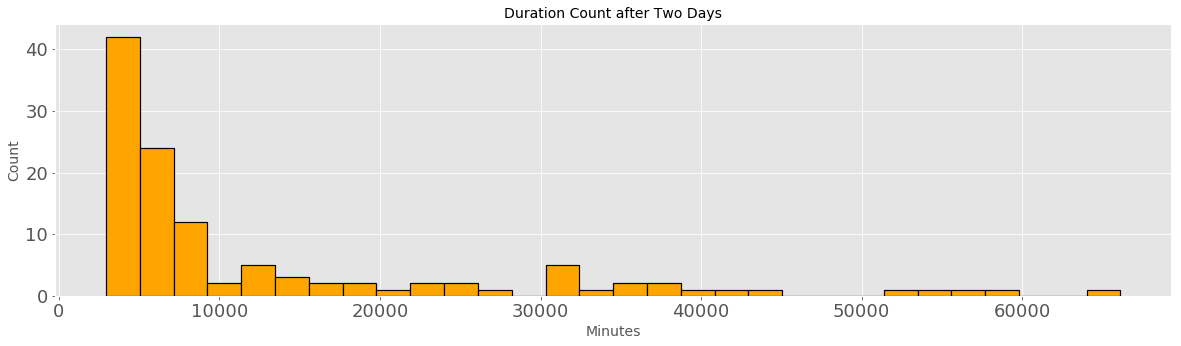

In [538]:
# What about those greater than two days (48 hours)
duration_out = sample.loc[(sample.tripduration / 60 >= (60 * 48))][['tripduration']] / 60
duration_out.hist(bins=30, histtype='bar', edgecolor='black', linewidth=1.2, align='mid', color='orange', figsize=(20,5))

# This was to look at the outliers (anything over a day is unnormal but data has better outliers)
plt.title('Duration Count after Two Days', fontsize=14)
plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Count', fontsize=14)

In [548]:
duration_out.describe()

,tripduration
count,116
mean,12847
std,14113
min,2932
25%,4343
50%,6325
75%,14405
max,66116


In [375]:
# When: Daily count of checkouts by hour
# Weekends and weekdays have different dynamics (i.e. work)
weekday = sample[sample.starttime.dt.weekday < 5]
weekend = sample[sample.starttime.dt.weekday >= 5]
weekday_countsPerHr = weekday.groupby(weekday.starttime.dt.hour).size()
weekend_countsPerHr = weekend.groupby(weekend.starttime.dt.hour).size()

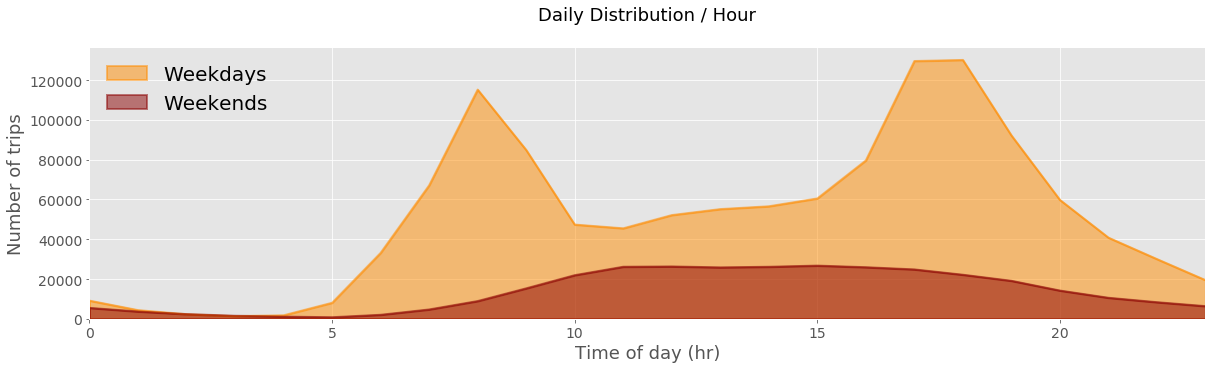

In [760]:
weekday_countsPerHr.plot(kind = 'area', stacked = False, figsize = (20, 5), color = 'darkorange', linewidth = 2, label='Weekdays')
weekend_countsPerHr.plot(kind = 'area', stacked = False, color = 'darkred', linewidth = 2, label='Weekends')

plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.title('Daily Distribution / Hour\n', fontsize = 18)
plt.xlabel('Time of day (hr)', fontsize = 18)
plt.ylabel('Number of trips', fontsize = 18)
legend = plt.legend(loc='upper left', frameon = False)

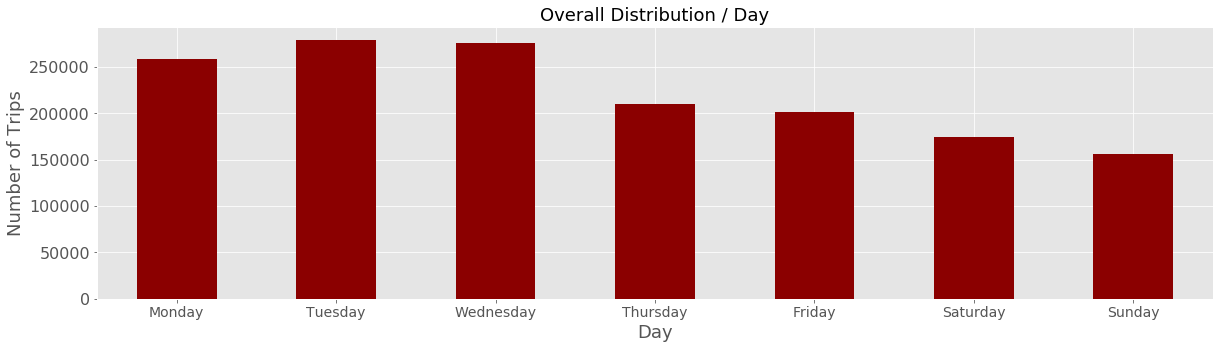

In [754]:
# When: Weekly count of checkouts by day
week_countsPerDay = sample.groupby(sample.starttime.dt.weekday).size()
week_countsPerDay.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_countsPerDay.plot(kind = 'bar', stacked = False, figsize = (20,5), color='darkred', linewidth=2, label='Month')

plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
plt.title('Overall Distribution / Day', fontsize=18)
plt.xticks(rotation=360, fontsize=14)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Number of Trips', fontsize=18)

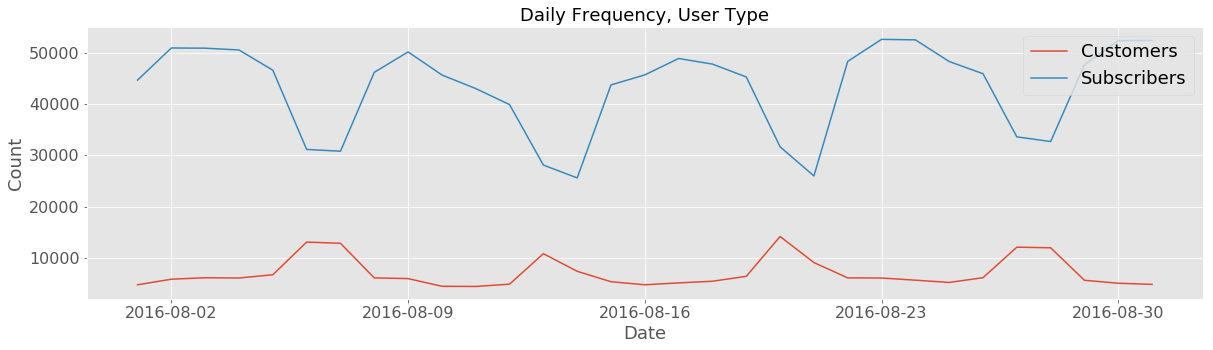

In [766]:
# Daily Distribution, Usertype
plt.figure(figsize=[20,5])
plt.plot(sample[sample['usertype']=='Customer'].starttime.dt.normalize().value_counts().sort_index())
plt.plot(sample[sample['usertype']=='Subscriber'].starttime.dt.normalize().value_counts().sort_index())
plt.title('Daily Frequency, User Type', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(loc='upper right', labels=users, fontsize=18)
plt.show()

Regardng 'when':
* Within an hour is sensible; half of the rides occur within 10 minutes.
* Over two days is not sensible; the highest count subsides within 10000 minutes (or seven days).
* Hourly distribution is divided by weekday and weekend; weekday activity is more than weekend activity.
* Citibikes are best for commutable work than recreation, by the two peaks occurring around work.  
* Daily distribution doesn't provide significance.  

Assuming Saturday and Sunday would have higher trip counts, the data shows trip counts occur during the weekdays.  And with Thursday and Friday having more count, it bolsters the weekday as a preferable period to use Citibike.  The month of August had three days of the week five times.  To conclude, with the exploration into 'when', one possible hypothesis is that whether the data skewness provides a strong error.

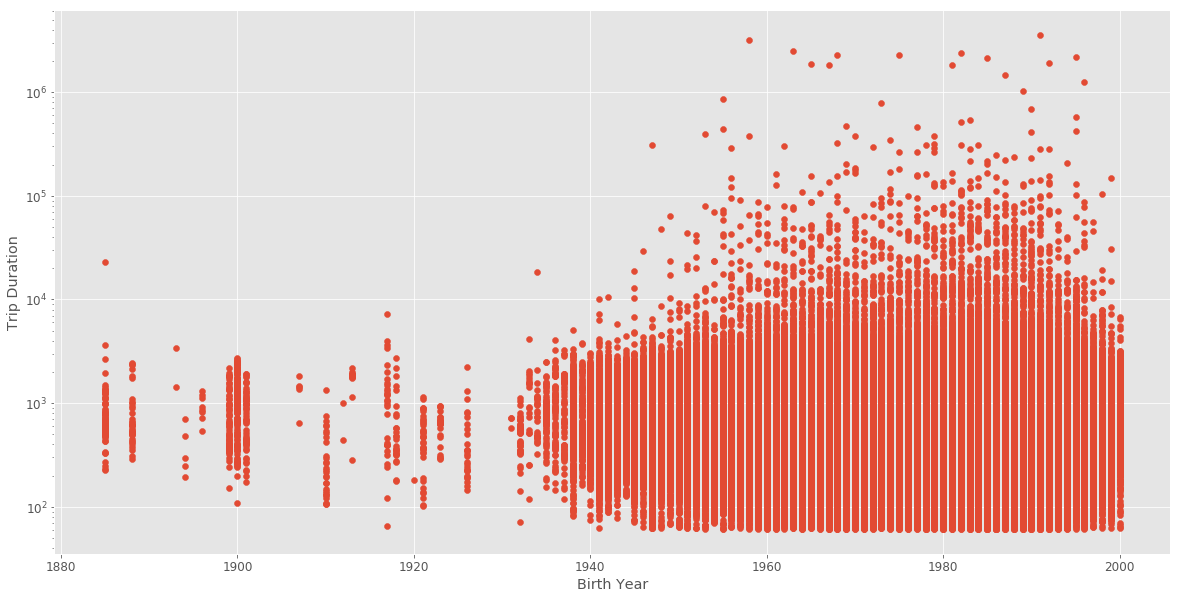

In [557]:
# HOW / Trip Duration by Birth Year: Here a scatterplot is used to compare the trip duration across birth year. 
plt.figure(figsize=[20,10])
plt.scatter(sample['birth year'], sample['tripduration'])
plt.xlabel('Birth Year')
plt.ylabel('Trip Duration')
plt.yscale('log')
plt.show()

In [558]:
# HOW / Trip Duration Boxplot by Gender: This shows the distributions by gender, less than 1 hr 
sample.groupby('gender')['tripduration'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
0,218533,1847,18880,61,817,1259,1702,3966943
1,999541,800,6891,61,363,588,976,3565469
2,339589,954,9506,61,433,699,1142,2497264


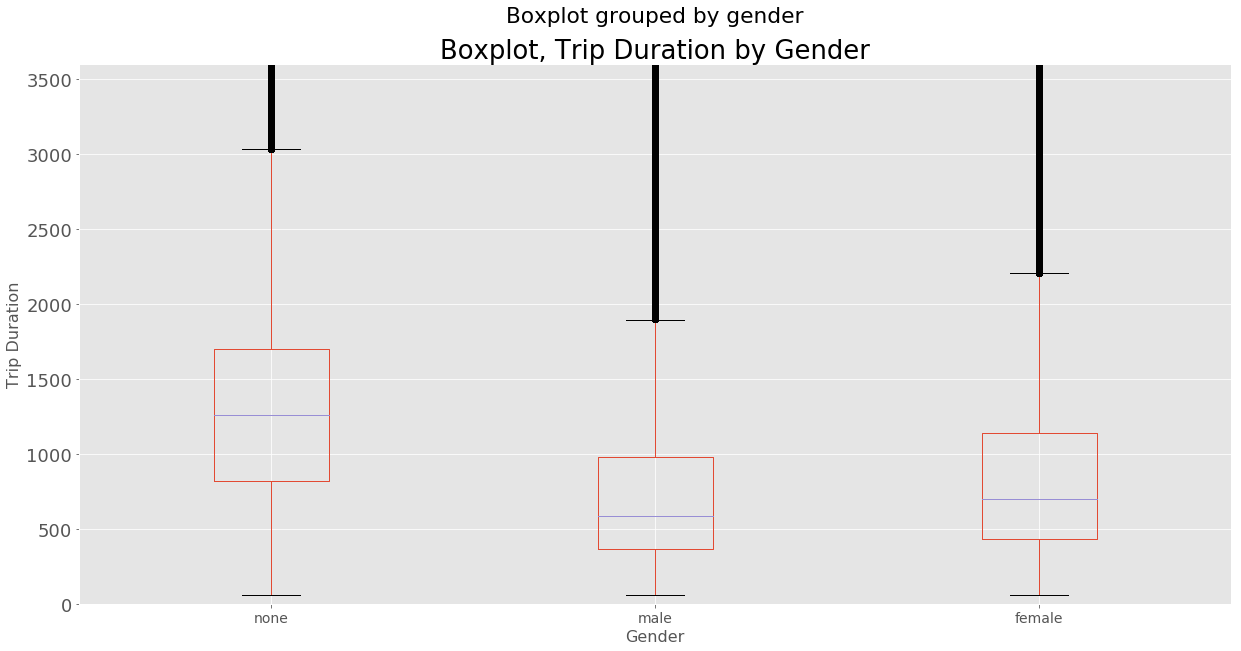

In [521]:
bp = sample.boxplot(column='tripduration', by='gender', grid=True, figsize=(20,10))
ax = plt.gca()

ax.set_title('Boxplot, Trip Duration by Gender')
ax.set_xlabel('Gender', fontsize=16)
ax.set_xticklabels(['none', 'male', 'female'], fontsize=14)
ax.set_ylabel('Trip Duration', fontsize=16)
ax.set_ylim([0,3600]) # less than 1 hr

plt.show()

In [543]:
# HOW / Trip Duration Boxplot by User Type: This shows the distributions by usertype, less than 1 hr
sample.groupby('usertype')['tripduration'].describe()

,count,mean,std,min,25%,50%,75%,max
usertype,,,,,,,,
Customer,218240,1868,18481,61,850,1282,1714,3966943
Subscriber,1339423,836,7801,61,377,612,1012,3565469


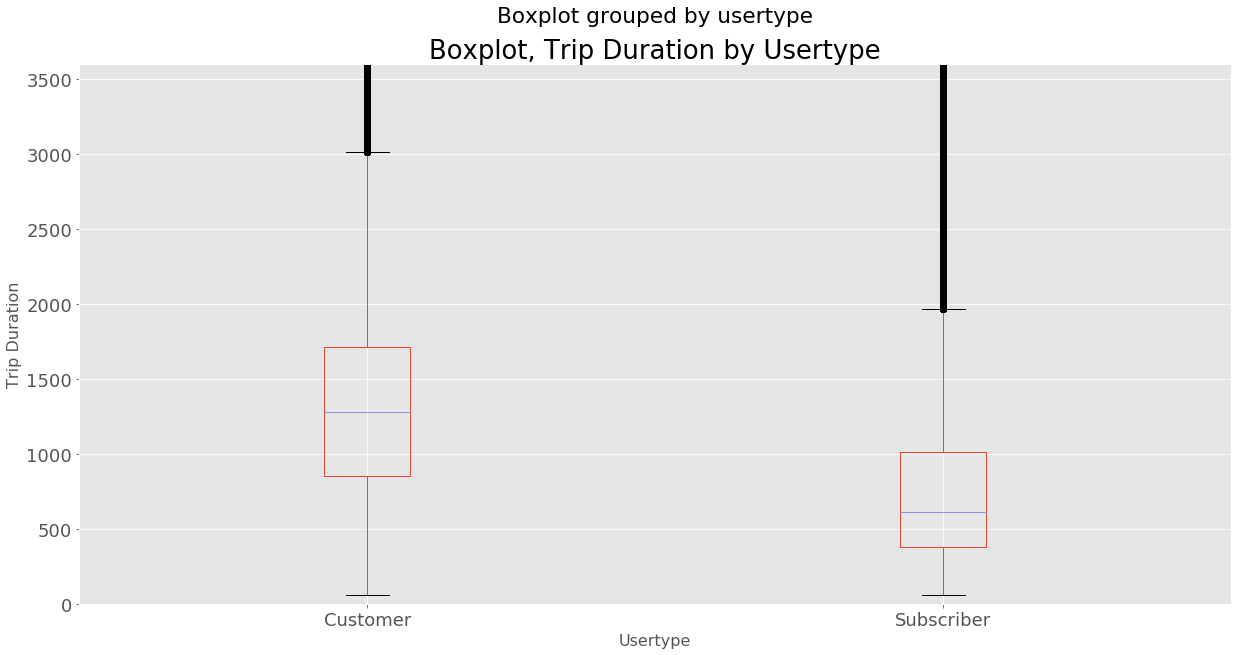

In [524]:
bp = sample.boxplot(column='tripduration', by='usertype', grid=True, figsize=(20,10))
ax = plt.gca()
ax.set_title('Boxplot, Trip Duration by Usertype')
ax.set_xlabel('Usertype', fontsize=16)
ax.set_ylabel('Trip Duration', fontsize=16)
ax.set_ylim([0,3600]) # less than 1 hr
plt.show()

The trip duration by birth year supports the marginal distribution of trip counts by age.  Creating a boxplot by age was unnecessary.  But focusing on gender and usertype provided something eye-opening.  Also, because of the outliers, the window was limited to 3600 seconds (1 hour) as over 75% of trips occur around this window.

* By gender: the most count (male) had a condensed boxplot than female.  This may imply that men (despite having the highest count) maybe using Citibike for their needs more.  The unknown variable (having the fewest count) did have a larger boxplot with a longer spread.
* By usertype: the largest count of trip comes from subscribers, yet they had a condensed boxplot than customers.  This doesn't make sense as subscribers have more allowable time (45 min vs 30 min for customers) to take out the bike.  

### PART 3 - Explore Data with Group
Now that we explored the data based on gender, user type, and birth year, it's time to add a new variable to simplify our data exploration.

The new significant variable is:
* Group type (categorical, five group types)

Possible explorations include:
* Trip distribution by age group (gender, usertype)
* Trip duration boxplot by groups (without outliers)
* Daily trip count by age group

In [658]:
# set up x axis regardless
x_pos=[0,1,2,3,4]
agename=['Unknown', 'Seniors', 'Adults', 'Juniors', 'Young']

# set up count by group, gender
m_group = sample[sample['gender']==1].groupby('agegroup')['agegroup'].count()/1000000
f_group = sample[sample['gender']==2].groupby('agegroup')['agegroup'].count()/1000000
u_group = sample[sample['gender']==0].groupby('agegroup')['agegroup'].count()/1000000

In [661]:
# set up count by group, usertype
s_group = sample[sample['usertype']=='Subscriber'].groupby('agegroup')['agegroup'].count()/1000000
c_group = sample[sample['usertype']=='Customer'].groupby('agegroup')['agegroup'].count()/1000000

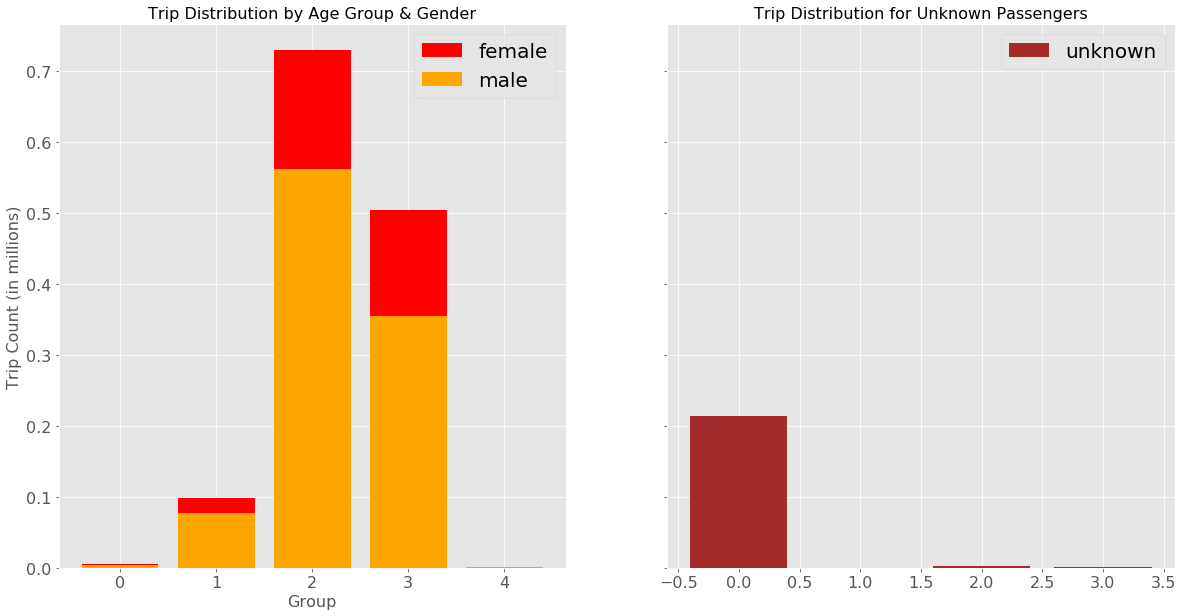

In [767]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

ax1.bar(x_pos, f_group, width=0.8, label='female', color='red', bottom=m_group)
ax1.bar(x_pos, m_group, width=0.8, label='male', color='orange')

ax1.set_ylabel("Trip Count (in millions)", fontsize=16)
ax1.set_xlabel("Group", fontsize=16)
# ax.set_xticklabels(('Unknown', 'Seniors', 'Adults', 'Juniors', 'Young'))
ax1.legend(loc="upper right")
ax1.set_title("Trip Distribution by Age Group & Gender", fontsize=16)

ax2.bar([0,1,2,3], u_group, width=0.8, label='unknown', color='brown')
ax2.legend(loc="upper right")
ax2.set_title("Trip Distribution for Unknown Passengers", fontsize=16)

plt.show()

# TALK TO NIK ABOUT THIS

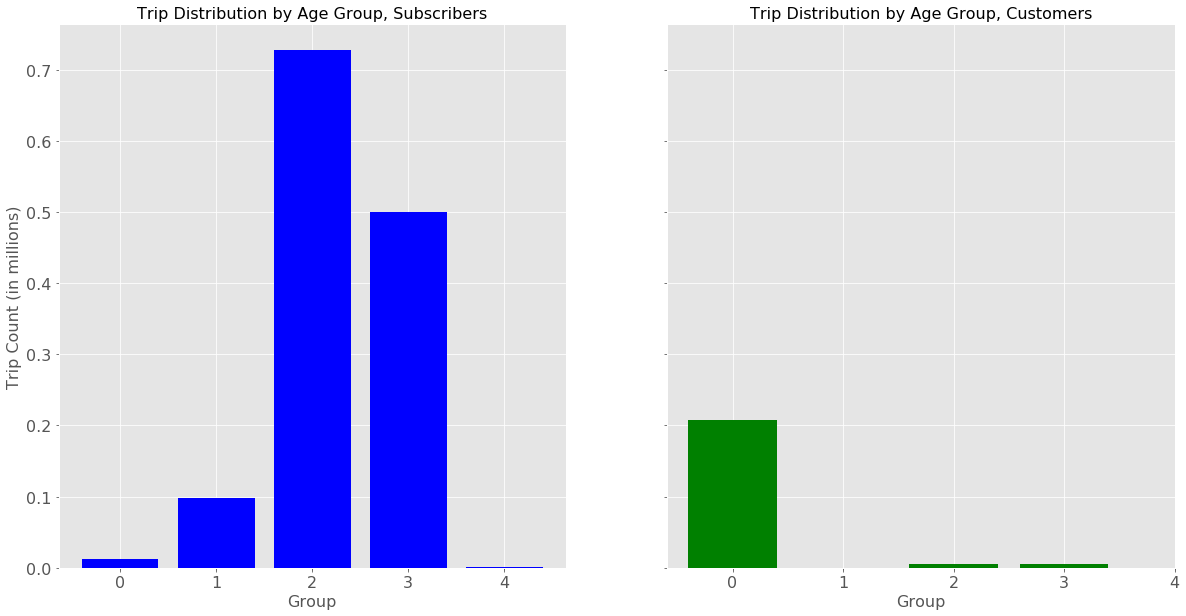

In [678]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

ax1.bar(x_pos, s_group, width=0.8, color='blue')
ax1.set_xticks(x_pos, agename)
ax1.set_ylabel("Trip Count (in millions)", fontsize=16)
ax1.set_xlabel("Group", fontsize=16)
ax1.set_title("Trip Distribution by Age Group, Subscribers", fontsize=16)

ax2.bar([0,1,2,3], c_group, width=0.8, color='green')
ax2.set_xticks(x_pos, agename)
ax2.set_xlabel("Group", fontsize=16)
ax2.set_title("Trip Distribution by Age Group, Customers", fontsize=16)

plt.show()

# TALK TO NIK ABOUT THIS

So the graphs provide an obvious clarification to the unknown variable.  It is clear that those with no birth year provided may be customers, but this includes customers as well.  When a customer purchases his/her day pass, they don't specify any further information than their credit card.  A possible extension is to dive deep into the correlation between unknown genders and unknown birth dates, but that's not what this exploration is aiming for.  Let's continue.

In [683]:
# Trip Duration Boxplot by Group
duration_by_group = sample.groupby('agegroup')['tripduration']
duration_by_group.describe()

,count,mean,std,min,25%,50%,75%,max
agegroup,,,,,,,,
0 UNK,219878,1825,18359,61,813,1256,1700,3966943
1 SEN,98826,903,10905,61,395,645,1079,3189634
2 ADL,732540,836,7134,61,376,608,1010,2497264
3 JNR,505780,836,8068,61,379,618,1019,3565469
4 YNG,639,945,793,62,393,744,1224,6835


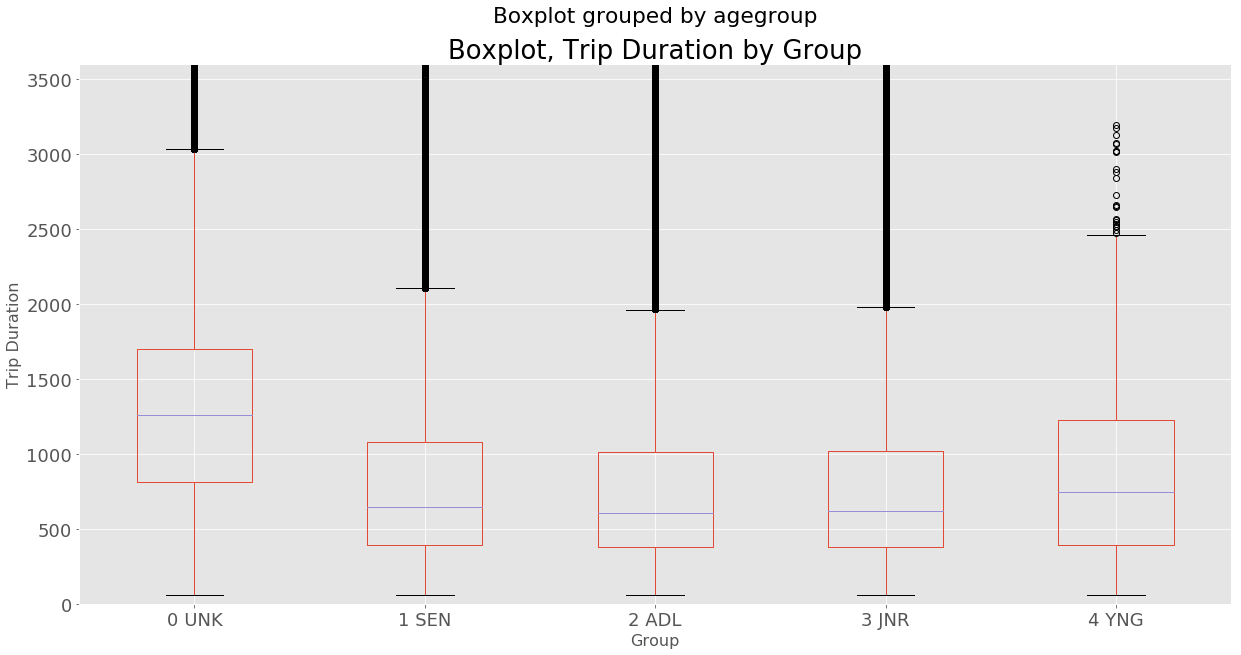

In [549]:
bp = sample.boxplot(column='tripduration', by='agegroup', grid=True, figsize=(20,10))
ax = plt.gca()
ax.set_title('Boxplot, Trip Duration by Group')
ax.set_xlabel('Group', fontsize=16)
ax.set_ylabel('Trip Duration', fontsize=16)
ax.set_ylim([0,3600]) # less than 1 hr
plt.show()

The boxplot shows something unusual.  While the Young group (4 YNG) has a self-contained boxplot (meaning that the outliers are clear and there is a beginning or end, due to a small size), only unknown has a large spread.  The others don't differ significantly from each other.  While their outliers may differ (see above), their boxplots look almost similar to each other in spread, median, IQR, and effect.  This is not what to expect and doesn't tell more beyond a typical duration.  One would expect it to increase in trip duration but that is not the case.  It seems that the customers are getting more from their use of Citibike than the subscribers. 

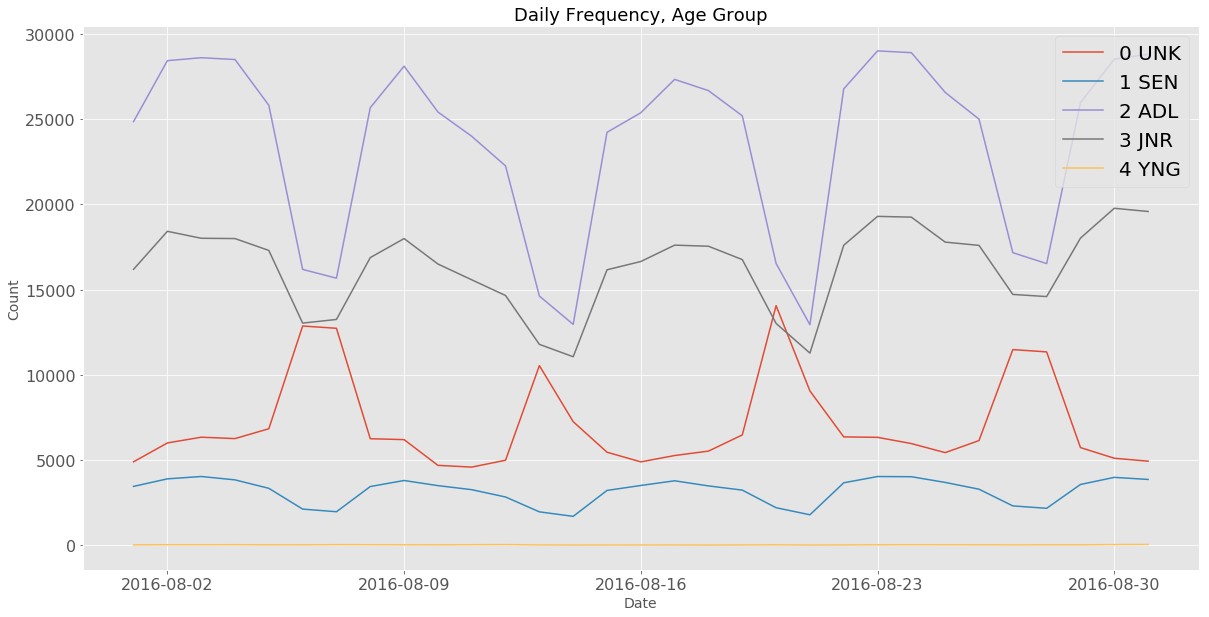

In [762]:
# Daily Distribution, Age Group
plt.figure(figsize=[20,10])
groups = ['0 UNK', '1 SEN', '2 ADL', '3 JNR', '4 YNG']
for name in groups:
    plt.plot(sample[sample['agegroup']==name].starttime.dt.normalize().value_counts().sort_index())
    
plt.title('Daily Frequency, Age Group', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.legend(loc="upper right", labels=groups)
plt.ylabel('Count', fontsize=14)
plt.show()

Finally the daily frequency for August 2016 a sinusoidal shape, oscillating from peaks to valleys.  Valleys are weekends and peaks may represent the workweek.  As supported, the top two frequencies are from '2 ADL' and '3 JNR'. What's interesting is that the unknown variable supercedes the '1 SEN' (those born middle of 1940s to 1960s), showing them as the largest count but little activity during the month.  This is a better projection of activity versus the previous graph (Overall Distribution by Day).  But this doesn't bolster the hypotheses for younger crowds, just as the explanatory analysis is showing this.    

### PART 4 - NEXT STEPS
After exploring the data, several hypotheses may be explored from the dataset.  The goal of these hypotheses is to wonder whether a monthly impact or observations will be true for a yearly reference.  They may include the following:

1. 1 SEN RISE: If this was taken for an entire year, would the generational statistics differ substantially one year from now than they are, now! 
2. 4 YNG RISE: What is the probability that as the bikeshare continues, younger generations will rise substantially?
3. FEMALE: One may explore the improvement of females throughout the year, whether they will converge toward the same statistics as men as the bikeshare program improves.
4. AGE DISTRIBUTION: Because the age distribution showed an interesting curve, if a year was taking would this shift more rightward and will see older audiences use the bike?  

These are possible questions.  Some have led to diverging possibilities and little exploration for a hypotheses.  If applying this on a larger dataset (one year), one would question whether the generational boxplot shown above will remain the same and whether if dividing it by gender would show some unique possibilities.  

*Questions for Nik*:
1. possible theories for inferential statistics and where to go from here
2. boxplot, removing super title
3. boxplot using group by function, five exact 
4. stacked bar graph, dealing with unequal groups (i.e. m,f 5 groups, u 1 group)